In [1]:
import logging

logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

import os
import sys

sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint, cic_paint_2d
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.lensing import density_plane

import jax_cosmo.constants as constants

from jax.scipy.ndimage import map_coordinates
from jaxpm.utils import gaussian_smoothing

import scipy

import astropy.units as u

import matplotlib.pyplot as plt

In [3]:
# Below are a few parameters that generate a low resolution version of the k-TNG simulation

box_size = [350.,350.,4000.]    # Transverse comoving size of the simulation volume
nc = [256, 256, 256]              # Number of transverse voxels in the simulation volume
plane_res = 64
lensplane_width = 200         # Width of each lensplane
# lensplane_width = 62.5         # Width of each lensplane
field_size = 5                  # Size of the lensing field in degrees
field_npix = 75                # Number of pixels in the lensing field
z_source = jnp.linspace(0,2)    # Source planes
seed = 2                        # Seed for nbody initial conditions

# Defining the coordinate grid for lensing map
xgrid, ygrid = jnp.meshgrid(jnp.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           jnp.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = jnp.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

# Cosmology 
cosmology = jc.Planck15(Omega_c=0.2589, sigma8=0.8159)

In [4]:
def convergence_Born(cosmo,
                     density_planes,
                     coords,
                     z_source):
  """
  Compute the Born convergence
  Args:
    cosmo: `Cosmology`, cosmology object.
    density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use 
    coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
    z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
    name: `string`, name of the operation.
  Returns:
    `Tensor` of shape [batch_size, N, Nz], of convergence values.
  """
  # Compute constant prefactor:
  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
  # Compute comoving distance of source galaxies
  r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))

  convergence = 0
  ims = []

  for entry in density_planes:
    r = entry['r']; a = entry['a']; p = entry['plane']
    dx = entry['dx']; dz = entry['dz']
    # Normalize density planes
    density_normalization = dz * r / a
    p = (p - p.mean()) * constant_factor * density_normalization

    foo = coords * r / dx - 0.5
    coords_in = foo + ((plane_res - 1 - foo.max()) / 2)

    # Interpolate at the density plane coordinates
    im = map_coordinates(p, 
                         coords_in, 
                         order=1, mode="constant")
    
    convergence += im * jnp.clip(1. - (r / r_s), 0, 1000).reshape([-1, 1, 1])
    ims.append(im)
  

  return convergence, r_s, ims

def nbody(Omega_c=0.2589, sigma8=0.8159, seed=0):
    # Instantiates a cosmology with desired parameters

    # Planning out the scale factor stepping to extract desired lensplanes
    n_lens = int(box_size[-1] // lensplane_width)
    r = jnp.linspace(0., box_size[-1], n_lens+1)
    r_center = 0.5*(r[1:] + r[:-1])

    # Retrieve the scale factor corresponding to these distances
    a = jc.background.a_of_chi(cosmology, r)
    a_center = jc.background.a_of_chi(cosmology, r_center)

    # Then one step per lens plane
    stages = a_center[::-1]

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(nc, box_size, pk_fn, seed=jax.random.PRNGKey(seed))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(nc), [particles+dx, p], 
                 jnp.concatenate([jnp.atleast_1d(0.1), stages]), cosmo, rtol=1e-5, atol=1e-5)
    
    return res, a_center, r_center

def get_planes(res, a_center, r_center, plane_res=64):
    stages = a_center[::-1]    
    # Extract the lensplanes
    lensplanes = []
    for i in range(len(a_center)):
        dx = box_size[0]/plane_res
        dz = lensplane_width
        plane = density_plane(res[0][::-1][i],
                              nc,
                              (i+0.5)*lensplane_width/box_size[-1]*nc[-1],
                              width=lensplane_width/box_size[-1]*nc[-1],
                              plane_resolution=plane_res
                           )
        lensplanes.append({'r': r_center[i], 
                           'a': stages[::-1][i], 
                           'plane': plane,
                           'dx':dx,
                           'dz':dz})
    return lensplanes

def interp_planes(cosmo, density_planes, coords): 
  #  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
   ims = []
   im_dicts = []

   for entry in density_planes:
    r = entry['r']; a = entry['a']; p = entry['plane']
    dx = entry['dx']; dz = entry['dz']
    # Normalize density planes
    # density_normalization = dz * r / a
    # p = (p - p.mean()) * constant_factor * density_normalization

    foo = coords * r / dx - 0.5
    coords_in = foo + ((plane_res - 1 - foo.max()) / 2)

    # Interpolate at the density plane coordinates
    im = scipy.ndimage.map_coordinates((p - p.mean()) / p.mean(), 
                         coords_in, 
                         order=1, mode="constant")
    
    ims.append(im)
    im_dicts.append({'r': r, 
                    'a': a, 
                    'plane': im,
                    'dx':dx,
                    'dz':dz})
   return ims, im_dicts
   

In [5]:
res, a_center, r_center = nbody(seed=seed)

2024-09-26 20:23:56.780170: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 40.72GiB (43722861537 bytes) by rematerialization; only reduced to 45.13GiB (48453649065 bytes), down from 47.00GiB (50466915105 bytes) originally


In [6]:
lensplanes = get_planes(res, a_center, r_center, plane_res=plane_res)

In [7]:
ims, dicts = interp_planes(cosmology, lensplanes, coords=jnp.array(c).T.reshape(2,field_npix,field_npix))

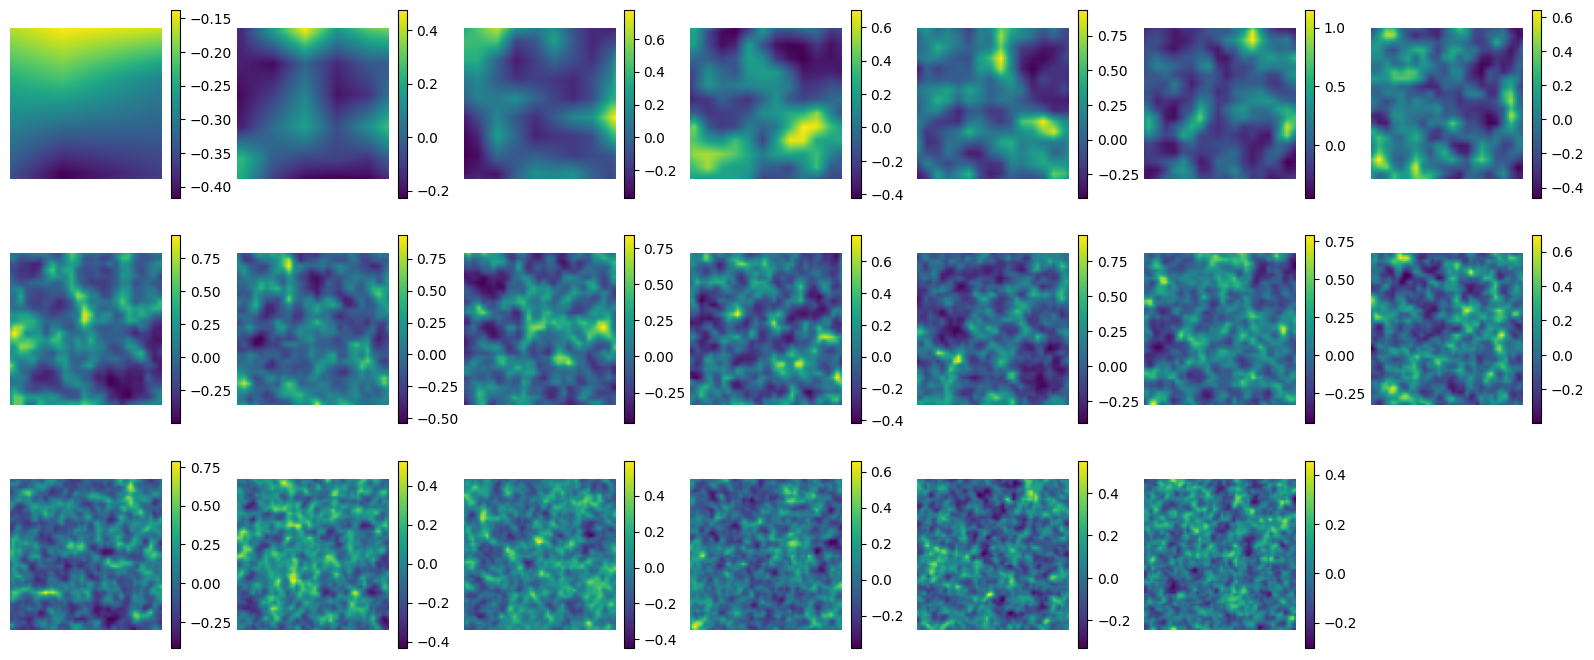

In [8]:
plt.figure(figsize=[20,20])
for i in range(len(ims)):
    plt.subplot(7,7,i+1)
    im = plt.imshow(ims[i])
    plt.colorbar(im)
    plt.axis('off')

In [ ]:
plt.figure(figsize=[20,20])
for i in range(len(ims)):
    plt.subplot(7,7,i+1)
    im = plt.imshow(lensplanes[i]['plane'])
    plt.colorbar(im)
    plt.axis('off')

In [9]:
jnp.save('../pm%d_good.npy'%seed, dicts, allow_pickle=True)
# jnp.save('../pm0_lensplanes_64.npy', lensplanes, allow_pickle=True)

In [ ]:
import matplotlib

cmap = matplotlib.colormaps['Greys']

for i in range(20): 
    ell_map, ps_map = measure_power_spectrum(ims[i], 1)
    plt.loglog(ell_map, ps_map, color=cmap(i/20))
# plt.loglog(elle, cls[0], label='ps theory', color='blue')
plt.show()

In [ ]:
m, r_s, ims = convergence_Born(cosmology, 
                        lensplanes,
                        coords=jnp.array(c).T.reshape(2,field_npix,field_npix),
                        z_source=z_source)

In [ ]:
plt.figure(figsize=[20,20])
for i in range(len(lensplanes)):
    plt.subplot(7,7,i+1)
    plt.imshow(lensplanes[i]['plane'])
    plt.axis('off')

In [ ]:
plt.imshow(-lensplanes[-1]['plane'], cmap='YlOrRd')
plt.axis('off')

In [ ]:
lp_list = [lensplanes[i]['plane'] for i in range(len(lensplanes))]
lp_arr = jnp.array(lp_list).transpose(1, 2, 0)
print(lp_arr.shape)

In [10]:
# jnp.save('../data/pm_640.npy', lp_arr)

In [ ]:
plt.figure(figsize=[10,10])
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.imshow(m[i+1])
    plt.axis('off')

In [ ]:
img = plt.imshow(m[-1])
plt.colorbar(img)
# plt.axis('off')
plt.show()

In [16]:
def radial_profile(data):
  """
  Compute the radial profile of 2d image
  :param data: 2d image
  :return: radial profile
  """
  center = data.shape[0]/2
  y, x = jnp.indices((data.shape))
  r = jnp.sqrt((x - center)**2 + (y - center)**2)
  r = r.astype('int32')

  tbin = jnp.bincount(r.ravel(), data.ravel())
  nr = jnp.bincount(r.ravel())
  radialprofile = tbin / nr
  return radialprofile

def measure_power_spectrum(map_data, pixel_size):
  """
  measures power 2d data
  :param power: map (nxn)
  :param pixel_size: pixel_size (rad/pixel)
  :return: ell
  :return: power spectrum
  
  """
  data_ft = jnp.fft.fftshift(jnp.fft.fft2(map_data)) / map_data.shape[0]
  nyquist = int(map_data.shape[0]/2)
  power_spectrum_1d =  radial_profile(jnp.real(data_ft*jnp.conj(data_ft)))[:nyquist] * (pixel_size)**2
  k = jnp.arange(power_spectrum_1d.shape[0])
  ell = 2. * jnp.pi * k / pixel_size / 360
  return ell, power_spectrum_1d

In [18]:
resolution = 1 # arcmin/pixel
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

# ps = measure_power_spectrum(m[-1]+1j*m[-1]*0.) * (pixel_size)**2
# k = jnp.arange(ps.shape[0])
# ell = 2. * jnp.pi * k / pixel_size / 360
# ell, ps = measure_power_spectrum(m[-1], pixel_size)

In [25]:
nzs = [jc.redshift.delta_nz(2.)]
probes = [jc.probes.WeakLensing(nzs, sigma_e=0.)]
elle = jnp.logspace(1, 5)
cls = jc.angular_cl.angular_cl(cosmology, elle, probes)

In [ ]:
plt.loglog(ell, ps, '--', label='ps from map')
plt.loglog(elle, cls[0], label='ps theory')
plt.legend()
plt.show()